# Линейная регрессия
__Суммарное количество баллов: 10__


In [311]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd

In [2]:
def read_data(path="./hw8_data/boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [3]:
def generate_synthetic(size, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Ее и нужно реализовать.

In [4]:
def mse(y_true, y_predicted):
    return np.mean((y_true - y_predicted)**2)

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [290]:
class NormalLR:
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y):
        X_c = np.concatenate((np.ones(X.shape[0]).reshape(-1, 1), X), axis=1)
        self.weights = np.linalg.inv(X_c.T @ X_c) @ X_c.T @ y
    
    def predict(self, X):
        X_c = np.concatenate((np.ones(X.shape[0]).reshape(-1, 1), X), axis=1)
        return X_c @ self.weights

In [291]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [292]:
regr = NormalLR()
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

0.008423154293436576


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [508]:
class GradientLR:
    def __init__(self, alpha, iterations=10000):
        self.alpha = alpha
        self.iterations = iterations
        self.weights = None
    
    def fit(self, X, y):
        X_c = np.concatenate((np.ones(X.shape[0]).reshape(-1, 1), X), axis=1)
        self.weights = np.zeros(X_c.shape[1])
            
        for _ in range(self.iterations):
            D = -2 * np.mean(X_c * (y - X_c @ self.weights).reshape(-1, 1), axis=0)
            self.weights -= self.alpha * D
    
    def predict(self, X):
        X_c = np.concatenate((np.ones(X.shape[0]).reshape(-1, 1), X), axis=1)
        return X_c @ self.weights

In [509]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [510]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

0.00938452867343315


### Задание 4 (2 балла)
Добавьте в метод `fit` регуляризацию Лассо с коэффициентом `l`. Постройте график зависимости ошибки предсказания данных из синтетического набора данных от коэффициента регуляризации.

In [511]:
class GradientLR:
    def __init__(self, alpha, iterations=10000, l=0.):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
        self.weights = None
    
    def fit(self, X, y):
        X_c = np.concatenate((np.ones(X.shape[0]).reshape(-1, 1), X), axis=1)
        self.weights = np.zeros(X_c.shape[1])
    
        for _ in range(self.iterations):
            y_pred = X_c.dot(self.weights)
            D = -2 * np.mean(X_c * (y - X_c @ self.weights).reshape(-1, 1), axis=0) + self.l * np.sign(self.weights)
            self.weights -= self.alpha * D
    
    def predict(self, X):
        X_c = np.concatenate((np.ones(X.shape[0]).reshape(-1, 1), X), axis=1)
        return X_c @ self.weights

In [512]:
def build_plot(X_train, y_train, X_test, y_test):
    l1_coefs = np.linspace(0, 5, 101)
    
    err = []
    
    for i, l in enumerate(l1_coefs):
        if i % 10 == 0:
            print(i, '/', len(l1_coefs))
        regr = GradientLR(0.01, iterations=1000, l=l)
        regr.fit(X_train, y_train)
        err.append(mse(y_test, regr.predict(X_test)))
    
    plt.plot(l1_coefs, err)

In [513]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

0.008651183734080005
0 / 101
10 / 101
20 / 101
30 / 101
40 / 101
50 / 101
60 / 101
70 / 101
80 / 101
90 / 101
100 / 101


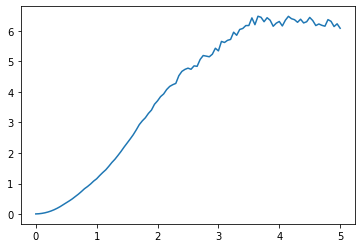

In [515]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))
build_plot(X_train, y_train, X_test, y_test)

### Задание 5 (2 балла)
Протесируйте оба метода на данных cancer и spam, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

# Cancer

In [516]:
data = pd.read_csv("./hw8_data/cancer.csv")
X, y = data.drop(columns=["label"]).values, data.label.map({"M": 0, "B": 1}).values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [517]:
regr = NormalLR()
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

0.05986875983440672


0.06380020367425385
0 / 101
10 / 101
20 / 101
30 / 101
40 / 101
50 / 101
60 / 101
70 / 101
80 / 101
90 / 101
100 / 101


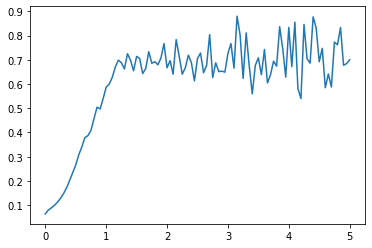

In [518]:
regr = GradientLR(0.01, iterations=1000)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))
build_plot(X_train, y_train, X_test, y_test)

# Spam

In [522]:
X, y = read_data('hw8_data/spam.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [523]:
regr = NormalLR()
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

0.18909584599550208


0.1890958187176244
0 / 101
10 / 101
20 / 101
30 / 101
40 / 101
50 / 101
60 / 101
70 / 101
80 / 101
90 / 101
100 / 101


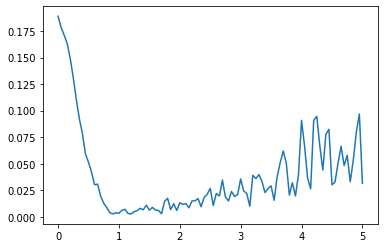

In [525]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))
build_plot(X_train, y_train, X_test, y_test)